In [1]:
# imports
import jax
jax.config.update("jax_default_device",jax.devices()[0])
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import jit,grad,jacfwd,jacrev,vmap
from jax.random import PRNGKey as pkey
from jax.scipy.linalg import solve
# Other libraries
import numpy as np
import matplotlib.pyplot as plt
from labellines import labelLines
from matplotlib.lines import Line2D
from tqdm.auto import tqdm
# plt.style.use("ggplot")
from importlib import reload

# Our libraries
import KernelTools
reload(KernelTools)
from KernelTools import *
from EquationModel import OperatorModel, OperatorPDEModel,CholInducedRKHS,InducedOperatorModel,SharedOperatorPDEModel
from plotting import plot_obs,plot_compare_error
from evaluation_metrics import get_nrmse,table_u_errors
from data_utils import (
    get_xy_grid_pairs,
    GP_sampler,
    build_xy_grid,
    sample_xy_grid_latin,
    build_input_observations,
    build_u_obs_single,
    build_u_obs_all,
    sample_multiple_xy_grids_latin
)

from Kernels import (
    get_gaussianRBF,
    get_centered_scaled_poly_kernel
)

import Optimizers
import importlib
importlib.reload(Optimizers)
from Optimizers.solvers_base import *

from Optimizers import BlockArrowLM,LMParams

# Other libraries
import numpy as np
import matplotlib.pyplot as plt
from labellines import labelLines
from matplotlib.lines import Line2D
plt.style.use('default')
import matplotlib.ticker as ticker
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    'font.size': 20
})

/home/juanfelipe/anaconda3/envs/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# in_sample errors
err_is = jnp.load('../in_sample/errors.npy', allow_pickle=True).item()
# in_distribution errors
err_id = jnp.load('../in_distribution/errors.npy', allow_pickle=True).item()
# out_distribution errors
err_od = jnp.load('../out_distribution/errors.npy', allow_pickle=True).item()
# operator_learning errors
err_ol = jnp.load('../operator_learning/errors.npy', allow_pickle=True).item()

## Error curves

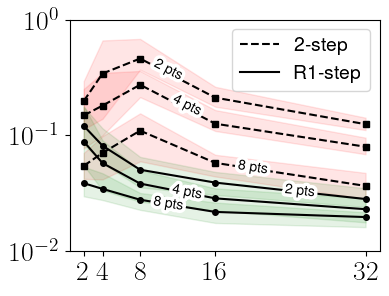

In [3]:
# in-sample errors plot
plt.figure(figsize=(4,3))
NUM_FUN_LIST = [2,4,8,16,32]
NUM_RUNS = 10
OBS_PTS_LIST = [2,4,8]
# plt.title('In sample error: u_new ~ GP(0,RBF(0.5))')
ms = NUM_FUN_LIST
# Colors
c2 = 'black'
c1 = 'black'
# 2-step method plot
for obs_pt in OBS_PTS_LIST:
    # 2 method
    mean_2 = jnp.array([jnp.mean(e) for e in jnp.array(err_is['2_mthd'][f'{obs_pt}_obs']['i_smpl'])])
    # sd_2 = jnp.array([jnp.std(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['i_smpl'])])
    upper_2 = jnp.array([jnp.nanmax(jnp.array(el)) for el in jnp.array(err_is['2_mthd'][f'{obs_pt}_obs']['i_smpl'])])
    lower_2 = jnp.array([jnp.nanmin(jnp.array(el)) for el in jnp.array(err_is['2_mthd'][f'{obs_pt}_obs']['i_smpl'])])
    # Plot 2 method
    plt.plot(ms, mean_2, label = f'{obs_pt} pts', marker= 's', linestyle = 'dashed',markersize = 4, color = c2)
    # plt.fill_between(ms, mean_2 - sd_2, mean_2 + sd_2, alpha=.1, color = 'red')
    plt.fill_between(ms, lower_2, upper_2, alpha=.1, color = 'red')
    plt.yscale('log')
    plt.minorticks_off()
# 1-step method plot
for obs_pt in OBS_PTS_LIST:
    # 1_5 method
    mean_1_5 = jnp.array([jnp.mean(e) for e in jnp.array(err_is['1_5_mthd'][f'{obs_pt}_obs']['i_smpl'])])
    # sd_1_5 = jnp.array([jnp.std(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['i_smpl'])])
    upper_1_5 = jnp.array([jnp.nanmax(jnp.array(el)) for el in jnp.array(err_is['1_5_mthd'][f'{obs_pt}_obs']['i_smpl'])])
    lower_1_5 = jnp.array([jnp.nanmin(jnp.array(el)) for el in jnp.array(err_is['1_5_mthd'][f'{obs_pt}_obs']['i_smpl'])])
    # Plot 1_5 method
    plt.plot(ms, mean_1_5, label = f'{obs_pt} pts', marker= 'o',markersize = 4, color = c1)
    # plt.fill_between(ms, mean_1_5 - sd_1_5, mean_1_5 + sd_1_5, alpha=.1, color = 'green')
    plt.fill_between(ms, lower_1_5, upper_1_5, alpha=.1, color = 'green')
    plt.yscale('log')
    plt.minorticks_off()

major_tick_labels = [r'$2$', r'$4$', r'$8$', r'$16$', r'$32$']
major_tick_positions = [2, 4, 8, 16, 32]
plt.xticks(ticks = major_tick_positions, 
           labels = major_tick_labels, 
           minor=False
           )
plt.ylim([1e-2,1e-0])
# plt.title(r'$\mathcal{R}_{\rm{eql}} \left((u^m)_{m=1}^M\right)$')
# plt.xlabel(r'$M$')
# adding labels to the plotlines
xvals_2step = [11,13,20]
xvals_1step = [25,13,11]
xvals = xvals_2step + xvals_1step
lines = plt.gca().get_lines()
labelLines(lines, align=True, xvals = xvals,fontsize=10)
# add legend box
legend_elements = [Line2D([0], [0], color= c2, linestyle = 'dashed', label='2-step'),
                   Line2D([0], [0], color= c1, label='R1-step')]
plt.legend(handles = legend_elements, loc = 'upper right', fontsize = 14)
plt.savefig('in_sample_errors.pdf',
            format = 'pdf',
            dpi = 300,
            bbox_inches='tight')
plt.show()

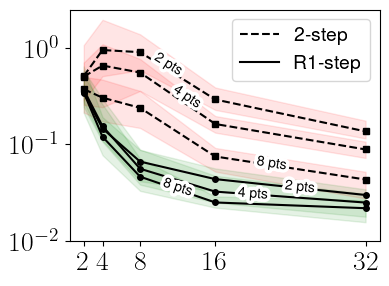

In [5]:
# in-distribution errors plot
plt.figure(figsize=(4,3))
NUM_FUN_LIST = [2,4,8,16,32]
NUM_RUNS = 10
OBS_PTS_LIST = [2,4,8]
# plt.title('In distribution error: u_new ~ GP(0,RBF(0.5))')
ms = NUM_FUN_LIST
# Colors
c2 = 'black'
c1 = 'black'

# 2-step method plot
for obs_pt in OBS_PTS_LIST:
    # 2 method
    mean_2 = jnp.array([jnp.mean(e) for e in jnp.array(err_id['2_mthd'][f'{obs_pt}_obs']['i_dis'])])
    # sd_2 = jnp.array([jnp.std(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['i_dis'])])
    upper_2 = jnp.array([jnp.nanmax(jnp.array(el)) for el in jnp.array(err_id['2_mthd'][f'{obs_pt}_obs']['i_dis'])])
    lower_2 = jnp.array([jnp.nanmin(jnp.array(el)) for el in jnp.array(err_id['2_mthd'][f'{obs_pt}_obs']['i_dis'])])
    # Plot 2 method
    plt.plot(ms, mean_2, label = f'{obs_pt} pts', marker= 's',linestyle='dashed',markersize = 4, color = c2)
    # plt.fill_between(ms, mean_2 - sd_2, mean_2 + sd_2, alpha=.1, color = 'red')
    plt.fill_between(ms, lower_2, upper_2, alpha=.1, color = 'red')
    plt.yscale('log')
    plt.minorticks_off()
# 1-step method plot
for obs_pt in OBS_PTS_LIST:
    # 1_5 method
    mean_1_5 = jnp.array([jnp.mean(e) for e in jnp.array(err_id['1_5_mthd'][f'{obs_pt}_obs']['i_dis'])])
    # sd_1_5 = jnp.array([jnp.std(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['i_dis'])])
    upper_1_5 = jnp.array([jnp.nanmax(jnp.array(el)) for el in jnp.array(err_id['1_5_mthd'][f'{obs_pt}_obs']['i_dis'])])
    lower_1_5 = jnp.array([jnp.nanmin(jnp.array(el)) for el in jnp.array(err_id['1_5_mthd'][f'{obs_pt}_obs']['i_dis'])])
    # Plot 1_5 method
    plt.plot(ms, mean_1_5, label = f'{obs_pt} pts', marker= 'o',markersize = 4, color = c1)
    # plt.fill_between(ms, mean_1_5 - sd_1_5, mean_1_5 + sd_1_5, alpha=.1, color = 'green')
    plt.fill_between(ms, lower_1_5, upper_1_5, alpha=.1, color = 'green')
    plt.yscale('log')
    plt.minorticks_off()


major_tick_labels = [r'$2$', r'$4$', r'$8$', r'$16$', r'$32$']
major_tick_positions = [2, 4, 8, 16, 32]
plt.xticks(ticks = major_tick_positions, 
           labels = major_tick_labels, 
           minor=False
           )
plt.ylim(bottom = 1e-2)
# plt.title(r'$\mathcal{R}_{\rm{eql}} \left(\mathcal{W}_{\rm{ID}}\right)$')
# plt.xlabel(r'$M$')
# adding labels to the plotlines
xvals_2step = [11,13,22]
xvals_1step = [25,20,12]
xvals = xvals_2step + xvals_1step
lines = plt.gca().get_lines()
labelLines(lines, align=True, xvals = xvals,fontsize=10)
# add legend box
legend_elements = [Line2D([0], [0], color= c2, linestyle='dashed', label='2-step'),
                   Line2D([0], [0], color= c1, label='R1-step')]
plt.legend(handles = legend_elements, loc = 'upper right', fontsize=14)
plt.savefig('in_distribution_errors.pdf',
            format = 'pdf',
            dpi = 300,
            bbox_inches='tight')
plt.show()

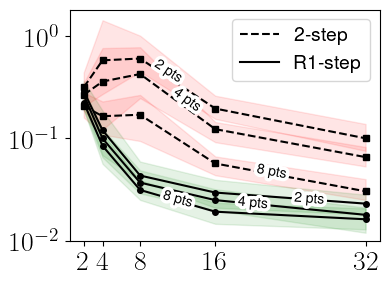

In [9]:
# out-distribution errors plot
plt.figure(figsize=(4,3))
NUM_FUN_LIST = [2,4,8,16,32]
NUM_RUNS = 10
OBS_PTS_LIST = [2,4,8]
# plt.title('Out of distribution error: u_new ~ GP(0,RBF(0.2))')
ms = NUM_FUN_LIST
# Colors
c2 = 'black'
c1 = 'black'
# 2-step method plot
for obs_pt in OBS_PTS_LIST:
    # 2 method
    mean_2 = jnp.array([jnp.mean(e) for e in jnp.array(err_od['2_mthd'][f'{obs_pt}_obs']['o_dis'])])
    # sd_2 = jnp.array([jnp.std(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['o_dis'])])
    upper_2 = jnp.array([jnp.nanmax(jnp.array(el)) for el in jnp.array(err_od['2_mthd'][f'{obs_pt}_obs']['o_dis'])])
    lower_2 = jnp.array([jnp.nanmin(jnp.array(el)) for el in jnp.array(err_od['2_mthd'][f'{obs_pt}_obs']['o_dis'])])
    # Plot 2 method
    plt.plot(ms, mean_2, label = f'{obs_pt} pts', marker= 's', linestyle = 'dashed',markersize = 4,color = c2)
    # plt.fill_between(ms, mean_2 - sd_2, mean_2 + sd_2, alpha=.1, color = 'red')
    plt.fill_between(ms, lower_2, upper_2, alpha=.1, color = 'red')
    plt.yscale('log')
    plt.minorticks_off()
# 1-step method plot
for obs_pt in OBS_PTS_LIST:
    # 1_5 method
    mean_1_5 = jnp.array([jnp.mean(e) for e in jnp.array(err_od['1_5_mthd'][f'{obs_pt}_obs']['o_dis'])])
    # sd_1_5 = jnp.array([jnp.std(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['o_dis'])])
    upper_1_5 = jnp.array([jnp.nanmax(jnp.array(el)) for el in jnp.array(err_od['1_5_mthd'][f'{obs_pt}_obs']['o_dis'])])
    lower_1_5 = jnp.array([jnp.nanmin(jnp.array(el)) for el in jnp.array(err_od['1_5_mthd'][f'{obs_pt}_obs']['o_dis'])])
    # Plot 1_5 method
    plt.plot(ms, mean_1_5, label = f'{obs_pt} pts', marker= 'o',markersize = 4, color = c1)
    # plt.fill_between(ms, mean_1_5 - sd_1_5, mean_1_5 + sd_1_5, alpha=.1, color = 'green')
    plt.fill_between(ms, lower_1_5, upper_1_5, alpha=.1, color = 'green')
    plt.yscale('log')
    plt.minorticks_off()

major_tick_labels = [r'$2$', r'$4$', r'$8$', r'$16$', r'$32$']
major_tick_positions = [2, 4, 8, 16, 32]
plt.xticks(ticks = major_tick_positions, 
           labels = major_tick_labels, 
           minor=False
           )
plt.ylim(bottom = 1e-2)
# plt.title(r'$\mathcal{R}_{\rm{eql}} \left(\mathcal{W}_{\rm{OOD}}\right)$')
# plt.xlabel(r'$M$')
# adding labels to the plotlines
xvals_2step = [11,13,22]
xvals_1step = [26,20,12]
xvals = xvals_2step + xvals_1step
lines = plt.gca().get_lines()
labelLines(lines, align=True, xvals = xvals,fontsize=10)
# add legend box
legend_elements = [Line2D([0], [0], color= c2, linestyle='dashed',label='2-step'),
                   Line2D([0], [0], color= c1, label='R1-step')]
plt.legend(handles = legend_elements, loc = 'upper right',fontsize=14)
plt.savefig('out_distribution_errors.pdf',
            format = 'pdf',
            dpi = 300,
            bbox_inches='tight')
plt.show()

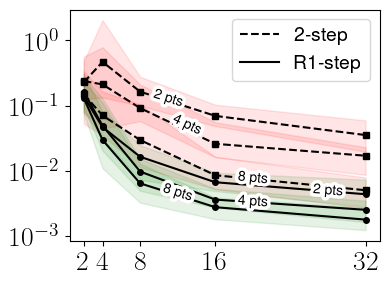

In [12]:
# operator_learning errors plot
plt.figure(figsize=(4,3))
NUM_FUN_LIST = [2,4,8,16,32]
NUM_RUNS = 10
OBS_PTS_LIST = [2,4,8]
# plt.title('Operator learning error: u_new ~ GP(0,RBF(0.5))')
ms = NUM_FUN_LIST
# Colors
c1 = 'black'
c2 = 'black'
# 2-step method plot
for obs_pt in OBS_PTS_LIST:
    # 2 method
    mean_2 = jnp.array([jnp.mean(e) for e in jnp.array(err_ol['2_mthd'][f'{obs_pt}_obs']['i_opt'])])
    # sd_2 = jnp.array([jnp.std(e) for e in jnp.array(err['2_mthd'][f'{obs_pt}_obs']['i_opt'])])
    upper_2 = jnp.array([jnp.nanmax(jnp.array(el)) for el in jnp.array(err_ol['2_mthd'][f'{obs_pt}_obs']['i_opt'])])
    lower_2 = jnp.array([jnp.nanmin(jnp.array(el)) for el in jnp.array(err_ol['2_mthd'][f'{obs_pt}_obs']['i_opt'])])
    # Plot 2 method
    plt.plot(ms, mean_2, label = f'{obs_pt} pts', marker= 's', linestyle = 'dashed',markersize = 4, color = c2)
    # plt.fill_between(ms, mean_2 - sd_2, mean_i_opt_2 + sd_i_opt_2, alpha=.1, color = 'red')
    plt.fill_between(ms, lower_2, upper_2, alpha=.1, color = 'red')
    plt.yscale('log')
    plt.minorticks_off()
# 1-step method plot
for obs_pt in OBS_PTS_LIST:
    # 1_5 method
    mean_1_5 = jnp.array([jnp.mean(e) for e in jnp.array(err_ol['1_5_mthd'][f'{obs_pt}_obs']['i_opt'])])
    # sd_1_5 = jnp.array([jnp.std(e) for e in jnp.array(err['1_5_mthd'][f'{obs_pt}_obs']['i_opt'])])
    upper_1_5 = jnp.array([jnp.nanmax(jnp.array(el)) for el in jnp.array(err_ol['1_5_mthd'][f'{obs_pt}_obs']['i_opt'])])
    lower_1_5 = jnp.array([jnp.nanmin(jnp.array(el)) for el in jnp.array(err_ol['1_5_mthd'][f'{obs_pt}_obs']['i_opt'])])
    # Plot 1_5 method
    plt.plot(ms, mean_1_5, label = f'{obs_pt} pts', marker= 'o',markersize = 4, color = c1)
    # plt.fill_between(ms, mean_1_5 - sd_1_5, mean_i_opt_1_5 + sd_i_opt_1_5, alpha=.1, color = 'green')
    plt.fill_between(ms, lower_1_5, upper_1_5, alpha=.1, color = 'green')
    plt.yscale('log')
    plt.minorticks_off()

major_tick_labels = [r'$2$', r'$4$', r'$8$', r'$16$', r'$32$']
major_tick_positions = [2, 4, 8, 16, 32]
plt.xticks(ticks = major_tick_positions, 
           labels = major_tick_labels, 
           minor=False
           )
# plt.ylim(top = 1e-0)
# plt.title(r'$\mathcal{R}_{\rm{opl}} \left(\mathcal{W}_{\rm{ID}}\right)$')
# plt.xlabel(r'$M$')


# adding labels to the plotlines
xvals_2step = [11,13,20]
xvals_1step = [28,20,12]
xvals = xvals_2step + xvals_1step
lines = plt.gca().get_lines()
labelLines(lines, align=True, xvals = xvals, fontsize = 10)
# add legend box
legend_elements = [Line2D([0], [0], color= c2, linestyle='dashed', label='2-step'),
                   Line2D([0], [0], color= c1, label='R1-step')]
plt.legend(handles = legend_elements, loc = 'upper right',fontsize=14)
plt.savefig('operator_learning_errors.pdf',
            format = 'pdf',
            dpi = 300,
            bbox_inches='tight')
plt.show()

## u's and f's

In [4]:
# generate u's and f's
m = 5
obs_pts = 2
run = 0
seed = int(m*obs_pts*(run+1))

# Sample m functions
kernel_GP = get_gaussianRBF(0.5)
xy_pairs = get_xy_grid_pairs(50,0,1,0,1) # Pairs to build interpolants
u_true_functions = tuple(GP_sampler(num_samples = m,
                                        X = xy_pairs, 
                                        kernel = kernel_GP,
                                        reg = 1e-12,
                                        seed = seed
                                    )
                                    )
# fine grid
xy_fine = jnp.vstack(build_xy_grid([0,1],[0,1],100,100))

# Permeability field A
def A(xy):
    x = xy[0]
    y = xy[1]
    return jnp.exp(jnp.sin(jnp.cos(x) + jnp.cos(y)))

# Compute f = Pu for a given u
def get_rhs_darcy(u):
    def Agradu(xy):
        return A(xy)*jax.grad(u)(xy)
    def Pu(xy):
        return jnp.trace(jax.jacfwd(Agradu)(xy))
    return Pu

In [5]:
# u's
u_s = tuple([jax.vmap(u) for u in u_true_functions])
u_trues_is = [u(xy_fine) for u in u_s]
# f
f_s = tuple([jax.vmap(get_rhs_darcy(u)) for u in u_true_functions])
f_trues_is = [f(xy_fine) for f in f_s]

In [6]:
# vmin and vmax to use same colors
u_s_stacked = jnp.stack(u_trues_is)
vmin_u_s, vmax_u_s = jnp.min(u_s_stacked), jnp.max(u_s_stacked)

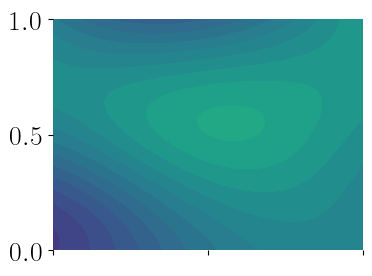

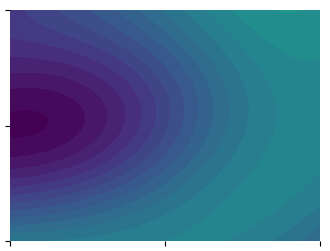

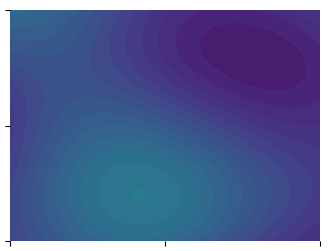

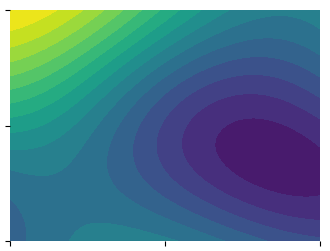

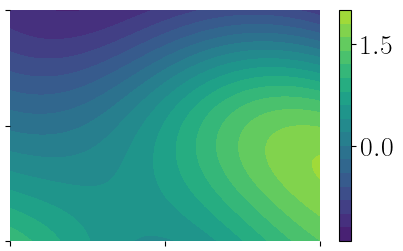

In [20]:
# u_true_is
for i in range(5):
    if i!= 4:
        plt.figure(figsize=(4,3))
    else:
        plt.figure(figsize=(5,3))
    cp = plt.tricontourf(*xy_fine.T, u_trues_is[i],
                    levels=15, 
                    vmin=vmin_u_s, 
                    vmax=vmax_u_s)
    
    # fig settings
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.locator_params(nbins=3)
    plt.gca().set_xticklabels([])
    
    # only left-most needs y tick labels
    if i != 0:
        plt.gca().set_yticklabels([])

    # only righ-most needs colorbar   
    if i == 4:  
        cb = plt.colorbar(cp)
        tick_locator = ticker.MaxNLocator(nbins=3)
        cb.locator = tick_locator
        cb.update_ticks()

    # save fig
    plt.savefig(f'darcy_u_is{i}.pdf',
                dpi=300,
                bbox_inches='tight',
                format ="pdf"
                )

In [19]:
# vmin and vmax to use same colors
f_s_stacked = jnp.stack(f_trues_is)
vmin_f_s, vmax_f_s = jnp.min(f_s_stacked), jnp.max(f_s_stacked)

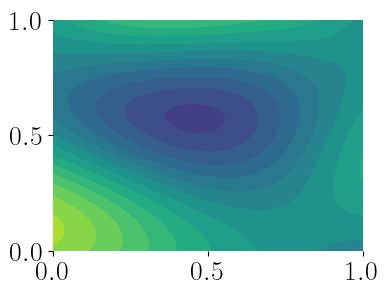

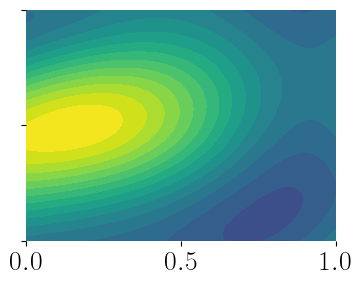

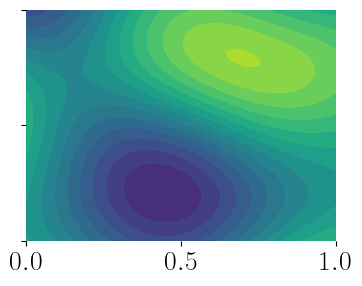

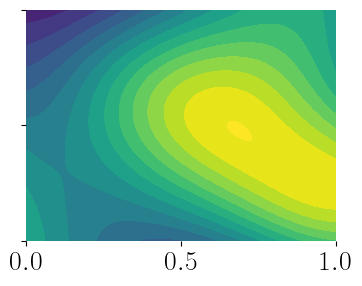

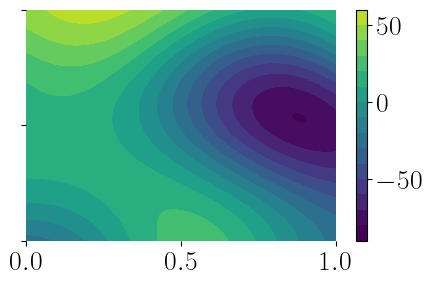

In [25]:
# f_true_is
for i in range(5):
    if i!= 4:
        plt.figure(figsize=(4,3))
    else:
        plt.figure(figsize=(5,3))
    cp = plt.tricontourf(*xy_fine.T, f_trues_is[i],
                    levels=15, 
                    vmin=vmin_f_s, 
                    vmax=vmax_f_s)
    
    # fig settings
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.locator_params(nbins=3)
    # plt.gca().set_xticklabels([])
    
    # only left-most needs y tick labels
    if i != 0:
        plt.gca().set_yticklabels([])

    # only righ-most needs colorbar   
    if i == 4:  
        cb = plt.colorbar(cp)
        tick_locator = ticker.MaxNLocator(nbins=3)
        cb.locator = tick_locator
        cb.update_ticks()

    # save fig
    plt.savefig(f'darcy_f_is{i}.pdf',
                dpi=300,
                bbox_inches='tight',
                format ="pdf"
                )

## f's

## errors one run